<a href="https://colab.research.google.com/github/calhounpaul/GPT-NeoX-20B-8bit-inference/blob/main/LLaMA_PEFT_LoRa_subreddit_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates Parameter Efficient Fine Tuning (PEFT) to create a chatbot from Facebook's LLaMA Large Language Model (LLM) on a public corpus (subreddit submissions and comments rearranged as chats).

Here's what you end up with after a few hours of fine tuning with an rtx 3090:

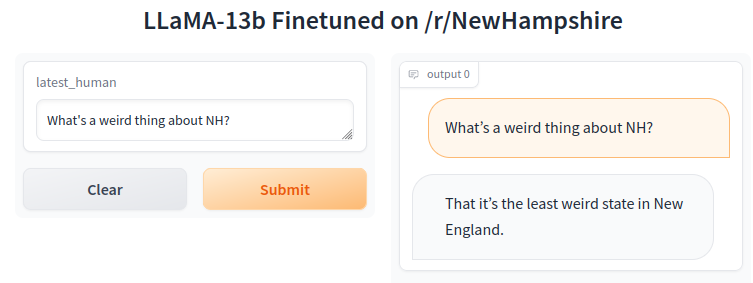


In [ ]:
import os, random, json, time, shutil, sys

You can change the model repo below if you've got a sufficiently large GPU. Decapoda put all four (7b, 13b, 30b[1] and 65b) versions on huggingface.

[1] *should be 33b, but isn't, due to an immortalized typo in the original facebook repo*

In [ ]:
MODEL_REPO = "decapoda-research/llama-7b-hf"

In [ ]:
THIS_DIR = os.getcwd()

Choose the subreddit you'd like to bring to life:

In [ ]:
SUBREDDIT_NAME = "wholesome"
START_YEAR = 2022
START_MONTH = 1
END_YEAR = 2022
END_MONTH = 3

We're going to use magnusnissel/ps_reddit_tool to download *very* large chunks of reddit archives. The submissions and comments from a single month can be upwards of 30GB, so expect to wait a while for both download and extraction.

In [ ]:
%cd {THIS_DIR}
!git clone https://github.com/magnusnissel/ps_reddit_tool
%cd ps_reddit_tool
!git checkout 0cb0bfd
!pip install --upgrade -qq -r requirements.txt

Since many of you will be using colab, now is a good time to establish some consolidated save points so the whole archive doesn't need to be downloaded repeatedly just to get the same list of comments.

It may also be more convenient to mount a google drive and load everything from there.

First, determine where the massive reddit files will go prior to extraction:

In [ ]:
REDDIT_LOC = os.path.join(THIS_DIR,"thisdayinreddit") #change to suit your needs
os.makedirs(REDDIT_LOC,exist_ok = True)

In [ ]:
!python3 cli.py config folder {REDDIT_LOC}

ps_reddit_tool allows for batch downloading, but we're going to do it in a loop so that we can skip whatever is already uploaded to {REDDIT_LOC}/extracted. So, if you're using a colab instance (hopefully not one with a GPU yet, since training hasn't started) you should try to download the extracted .json files in {REDDIT_LOC}/extracted/monthly/{SUBREDDIT_NAME} as they appear. That way, you can re-upload them if you lose the instance, and they'll be skipped.

In [ ]:
completed_extractions_loc = os.path.join(REDDIT_LOC,"extracted","monthly",SUBREDDIT_NAME)
os.makedirs(completed_extractions_loc,exist_ok = True)
print(completed_extractions_loc)
zipped_archives_loc = os.path.join(REDDIT_LOC,"compressed")

If you're restarting, you should stop here and drop the json files into the completed extractions directory printed above. Otherwise, you can just move on.

Here's a toggle to choose if you'd like to delete the reddit archives from disk after download and extraction:

In [ ]:
DELETE_ARCHIVES_AFTER_EXTRACTION = False

In [ ]:
completed_extractions_filenames = os.listdir(completed_extractions_loc)

In [ ]:
for this_year in range(START_YEAR,END_YEAR+1):
    this_start_month = START_MONTH if this_year == START_YEAR else 1
    this_end_month = END_MONTH if this_year == END_YEAR else 12
    for this_month in range(this_start_month,this_end_month+1):
        print("MONTH",this_month,"YEAR",this_year)
        date_str = str(this_year)+"-"+str(this_month).zfill(2)
        filename_tail = "_"+SUBREDDIT_NAME+"_"+date_str+".json"
        if "RS"+filename_tail not in completed_extractions_filenames:
            !python3 cli.py submissions download {date_str} {date_str} # --force=True
            !python3 cli.py submissions extract {date_str} {date_str} {SUBREDDIT_NAME}
        if "RC"+filename_tail not in completed_extractions_filenames:
            !python3 cli.py comments download {date_str} {date_str} # --force=True
            !python3 cli.py comments extract {date_str} {date_str} {SUBREDDIT_NAME}
        if DELETE_ARCHIVES_AFTER_EXTRACTION:
            shutil.rmtree(zipped_archives_loc)

Your chosen subreddit's extracted data should now be locally available in JSON files that can be used to construct linear conversations for training an LLM to behave as a chatbot.

We'll be using redditcleaner to clean the text.

In [ ]:
!pip3 install -qq redditcleaner
import redditcleaner

Now load the submission and comment lists into memory. Everything will be linked up in a moment. There's probably a cleaner way to do this, but it already takes a negligible amount of time relative to the rest of this notebook.

In [ ]:
comments = []
submissions = []

for filename in os.listdir(completed_extractions_loc):
    if not filename.endswith(".json"):
        continue
    with open(os.path.join(completed_extractions_loc,filename),"r") as f:
        try:
            if filename.startswith("RC"):
                comments += json.load(f)
            elif filename.startswith("RS"):
                submissions+= json.load(f)
        except:
            print(filename,"failed")
            pass

Now organize submissions and comments by id:

In [ ]:
submissions_by_id = {}
for sub in submissions:
    submissions_by_id[sub["id"]] = sub

comments_by_id = {}
for comment in comments:
    comments_by_id[comment["id"]] = comment
    try:
        comments_by_id[comment["id"]]["pid"]=comment["parent_id"].split("_")[-1]
    except:
        comments_by_id[comment["id"]]["pid"]= None

Construct lists of parent comment IDs and childless comment IDs:

In [ ]:
parents_list = set()
for id in comments_by_id:
    if comments_by_id[id]["pid"]:
        parents_list.add(comments_by_id[id]["pid"])

parents_list = list(parents_list)

leaf_list = set()
for id in comments_by_id:
    if comments_by_id[id]["pid"]:
        if id not in parents_list:
            leaf_list.add(id)

leaf_list = list(leaf_list)

Each childless comment forms a unique chat conversation (with the original reddit submission as the first message) that can be followed upstream to the initial parent, which can then be represented in the chat as a reply to the first message. (note: initial comments will be overrepresented with this method).

In [ ]:
chats_list = []
for leaf_id in leaf_list:
    this_chat = [leaf_id,]
    if leaf_id not in comments_by_id:
        continue
    skip = False
    while this_chat[0] in comments_by_id:
        if comments_by_id[this_chat[0]]["body"] == "[deleted]" or \
            comments_by_id[this_chat[0]]["author"] == "[deleted]":
            skip = True
            break
        this_chat = [comments_by_id[this_chat[0]]["pid"],] + this_chat
    if skip:
        continue
    if this_chat[0] not in submissions_by_id:
        continue
    if len(this_chat)<3:
        continue
    if "selftext" in submissions_by_id[this_chat[0]]:
        if submissions_by_id[this_chat[0]]["selftext"] == "[removed]":
            continue
    chats_list.append(this_chat)

Now the list of chats (message lists) can be formatted according to preference. I chose <human_##> and <bot>.

These constants determine formatting:

In [ ]:
name_separator = ": "
message_separator = "\n"
human_username_replacements = ["<human_" + str(n).zfill(2) + ">" for n in range(200)]
bot_username = "<bot>"

Comments don't have separate titles, but self posts do, so the first message for chats constructed from self posts will use a random one of these as a separator between the title and body:

In [ ]:
title_body_separators = [": "," - ","\n"]

clean_text_body can be modified for different purposes. I've set it up to just remove all double spaces and run redditcleaner on the text.

In [ ]:
final_training_strings = []

def clean_text_body(input_text):
    while "\n\n" in input_text:
        input_text = input_text.replace("\n\n","\n")
    input_text = redditcleaner.clean(input_text)
    return input_text.strip()

for chat in chats_list:
    train_string = ""
    submission_data = submissions_by_id[chat[0]]
    authors_map = {submission_data["author"]:human_username_replacements[0],}
    train_string += authors_map[submission_data["author"]]
    train_string += name_separator
    train_string += submission_data["title"]
    if submission_data["domain"].startswith("self."):
        if len(submission_data["selftext"]):
            if train_string.endswith("."):
                train_string = train_string[:-1]
            train_string += random.choice(title_body_separators) + clean_text_body(submission_data["selftext"])
    elif "url" in submission_data:
        pass
        #train_string += random.choice(title_body_separators) + submission_data["url"]
    non_op_author_scores = {}
    top_author_score = 0
    top_scoring_author = None
    names_iterator = 1
    skip = False
    for msg_id in chat[1:]:
        msg = comments_by_id[msg_id]
        if msg["author"] == submission_data["author"]:
            continue
        if msg["author"] not in non_op_author_scores:
            non_op_author_scores[msg["author"]] = 0
        if msg["author"] not in authors_map:
            authors_map[msg["author"]] = human_username_replacements[names_iterator]
            names_iterator+=1
        non_op_author_scores[msg["author"]] += msg["score"]
        if non_op_author_scores[msg["author"]] > top_author_score:
            top_author_score = non_op_author_scores[msg["author"]]
            top_scoring_author = msg["author"]
    if skip:
        continue
    if top_author_score < 0:
        continue
    authors_map[top_scoring_author] = bot_username
    for msg_id in chat[1:]:
        msg = comments_by_id[msg_id]
        train_string+=message_separator+authors_map[msg["author"]]+name_separator
        train_string+=clean_text_body(msg["body"])
    final_training_strings.append({"text":train_string,})

train_path = os.path.join(THIS_DIR,"dataset.json")
with open(train_path,"w") as f:
    json.dump(final_training_strings,f)

The training part is mostly modified code from the alpaca-lora repo: https://github.com/tloen/alpaca-lora

I'll update it later.

In [ ]:
!pip3 install --upgrade datasets
!pip3 install --upgrade loralib
!pip3 install --upgrade sentencepiece
!pip3 install --upgrade git+https://github.com/huggingface/transformers.git
!pip3 install --upgrade accelerate
!pip3 install --upgrade bitsandbytes
!pip3 install --upgrade git+https://github.com/huggingface/peft.git
!pip3 install --upgrade gradio
!pip3 install --upgrade appdirs

In [ ]:
from typing import List

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import fire
import torch
import torch.nn as nn
import bitsandbytes as bnb
from datasets import load_dataset
import transformers

assert (
    "LlamaTokenizer" in transformers._import_structure["models.llama"]
), "LLaMA is now in HuggingFace's main branch.\nPlease reinstall it: pip uninstall transformers && pip install git+https://github.com/huggingface/transformers.git"
from transformers import LlamaForCausalLM, LlamaTokenizer, GenerationConfig
from peft import (
    prepare_model_for_int8_training,
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    PeftModel,
)

I recommend trying this multiple times and varying your hyperparams.

In [ ]:
# model/data params
base_model = MODEL_REPO  # the only required argument
data_path = train_path
output_dir = os.path.join(THIS_DIR,SUBREDDIT_NAME+"_llama")
# training hyperparams
batch_size = 128
micro_batch_size = 4
num_epochs = 3
learning_rate = 1e-4
cutoff_len = 512
val_set_size = 200
# lora hyperparams
lora_r = 8
lora_alpha = 16
lora_dropout = 0.05
lora_target_modules = [
    "q_proj",
    "v_proj",
]
# llm hyperparams
train_on_inputs = True  # if False, masks out inputs in loss
group_by_length = True  # faster, but produces an odd training loss curve

In [ ]:
print(
    f"Training Alpaca-LoRA model with params:\n"
    f"base_model: {base_model}\n"
    f"data_path: {data_path}\n"
    f"output_dir: {output_dir}\n"
    f"batch_size: {batch_size}\n"
    f"micro_batch_size: {micro_batch_size}\n"
    f"num_epochs: {num_epochs}\n"
    f"learning_rate: {learning_rate}\n"
    f"cutoff_len: {cutoff_len}\n"
    f"val_set_size: {val_set_size}\n"
    f"lora_r: {lora_r}\n"
    f"lora_alpha: {lora_alpha}\n"
    f"lora_dropout: {lora_dropout}\n"
    f"lora_target_modules: {lora_target_modules}\n"
    f"train_on_inputs: {train_on_inputs}\n"
    f"group_by_length: {group_by_length}\n"
)

gradient_accumulation_steps = batch_size // micro_batch_size

device_map = "auto"
world_size = 1

model = LlamaForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=True,
    device_map=device_map,
)

tokenizer = LlamaTokenizer.from_pretrained(base_model)

tokenizer.pad_token_id = 0  # unk. we want this to be different from the eos token
tokenizer.padding_side = "left"  # Allow batched inference

def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = data_point["text"]
    tokenized_full_prompt = tokenize(full_prompt)
    if not train_on_inputs:
        user_prompt = generate_prompt({**data_point, "output": ""})
        tokenized_user_prompt = tokenize(user_prompt, add_eos_token=False)
        user_prompt_len = len(tokenized_user_prompt["input_ids"])

        tokenized_full_prompt["labels"] = [
            -100
        ] * user_prompt_len + tokenized_full_prompt["labels"][
            user_prompt_len:
        ]  # could be sped up, probably
    return tokenized_full_prompt

model = prepare_model_for_int8_training(model)

config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    target_modules=lora_target_modules,
    lora_dropout=lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)

data = load_dataset("json", data_files=data_path)

if val_set_size > 0:
    train_val = data["train"].train_test_split(
        test_size=val_set_size, shuffle=True, seed=42
    )
    train_data = train_val["train"].shuffle().map(generate_and_tokenize_prompt)
    val_data = train_val["test"].shuffle().map(generate_and_tokenize_prompt)
else:
    train_data = data["train"].shuffle().map(generate_and_tokenize_prompt)
    val_data = None

from transformers import TrainerCallback

#class SaveCallback(TrainerCallback):
#    def on_step_end(self, args, state, control, **kwargs):
#        if state.global_step % interval == 0:
#           pass

os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=micro_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        warmup_steps=10,
        num_train_epochs=num_epochs,
        learning_rate=learning_rate,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps" if val_set_size > 0 else "no",
        save_strategy="steps",
        eval_steps=10 if val_set_size > 0 else None,
        save_steps=100,
        output_dir=output_dir,
        save_total_limit=3,
        load_best_model_at_end=True if val_set_size > 0 else False,
        group_by_length=group_by_length,
    ),
    data_collator=transformers.DataCollatorForSeq2Seq(
        tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    ),
    #callbacks=[SaveCallback],
)
model.config.use_cache = False

old_state_dict = model.state_dict
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(self, old_state_dict())
).__get__(model, type(model))

if torch.__version__ >= "2" and sys.platform != "win32":
    model = torch.compile(model)

resume_from_checkpoint = False
if os.path.exists(output_dir):
    if len([n for n in os.listdir(output_dir) if n.startswith("checkpoint")]):
        resume_from_checkpoint = True
trainer.train(resume_from_checkpoint=resume_from_checkpoint)

model.save_pretrained(output_dir)

print("\n If there's a warning about missing keys above, please disregard :)")

The PEFT weights are efficient because they store only the fine-tuned parameters (hence the name). In theory, this could allow a single pretrained LLM to have many small hot-swappable fine-tuned files specialized for different tasks, e.g. one for self-reflection, one for sentiment analysis, one for summarization, etc.

(I demonstrated some of GPT-Neox-20B's few-shot abilities here: https://github.com/calhounpaul/GPT-NeoX-20B-8bit-inference, so task-specific fine-tuning should mostly be a matter of pushing the network into the right state to make use of an existing talent).

This next part reintegrates the PEFT weights into the original model for uploading to HF. This lets other people use it directly, without bothering with PEFT. You can also push the PEFT weights alone, which saves a lot of bandwidth for people who already have LLaMA.

In [ ]:
del model

base_model = LlamaForCausalLM.from_pretrained(
    MODEL_REPO,
    load_in_8bit=False,
    torch_dtype=torch.float16,
    device_map={"": "cpu"},
)

first_weight = base_model.model.layers[0].self_attn.q_proj.weight
first_weight_old = first_weight.clone()

lora_model = PeftModel.from_pretrained(
    base_model,
    output_dir,
    device_map={"": "cpu"},
    torch_dtype=torch.float16,
)

lora_weight = lora_model.base_model.model.model.layers[0].self_attn.q_proj.weight

assert torch.allclose(first_weight_old, first_weight)

# merge weights
for layer in lora_model.base_model.model.model.layers:
    layer.self_attn.q_proj.merge_weights = True
    layer.self_attn.v_proj.merge_weights = True

lora_model.train(False)

# did we do anything?
assert not torch.allclose(first_weight_old, first_weight)

lora_model_sd = lora_model.state_dict()
deloreanized_sd = {
    k.replace("base_model.model.", ""): v
    for k, v in lora_model_sd.items()
    if "lora" not in k
}

new_hf_model_ckpt = os.path.join(THIS_DIR,"hf_ckpt")
LlamaForCausalLM.save_pretrained(
    base_model, new_hf_model_ckpt, state_dict=deloreanized_sd, max_shard_size="400MB"
)

print("HF model exported to",new_hf_model_ckpt)


Now you have a fully-HF-compatible model that can be shared on the hub: https://huggingface.co/docs/transformers/model_sharing

Here's a very rudimentary gradio chatbot interface:

In [ ]:
CREATE_TEMPORARY_PUBLIC_CHATBOT_URL_FOR_SHARING = True

import gradio

del base_model
#del model

device = "cuda"

model = LlamaForCausalLM.from_pretrained(
    os.path.join(THIS_DIR,"hf_ckpt"),
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map={"": 0} #"auto",
)
# unwind broken decapoda-research config
model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
model.config.bos_token_id = 1
model.config.eos_token_id = 2

model.eval()
if torch.__version__ >= "2" and sys.platform != "win32":
    model = torch.compile(model)
def evaluate(
        prompt,
        eos_strings =["<human","<bot>:"],
        temperature=0.1,
        top_p=0.75,
        top_k=40,
        num_beams=4,
        max_new_tokens=128,
        **kwargs,
    ):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    with open("logs/" + str(time.time()) + ".txt","w") as f:
        f.write("prompt: "+prompt+"\n\noutput: "+output)
    new_generated_part = output[len(prompt)+1:]
    for eos_str in eos_strings:
        new_generated_part = new_generated_part.split(eos_str)[0].strip()
    return new_generated_part
os.makedirs("logs",exist_ok=True)
def chat_cb(latest_human,history=[]):
    conv_string = ""
    for conv_pair in history:
        human_msg = BeautifulSoup(conv_pair[0]).text
        bot_msg = BeautifulSoup(conv_pair[1]).text
        conv_string += "<human_00>: " + conv_pair[0] + "\n<bot>: " + conv_pair[1] + "\n"
    conv_string += "<human_00>: " + latest_human + "\n<bot>:"
    bot_reply = evaluate(conv_string).replace("\n","<br>")
    history.append([latest_human.replace("\n","<br>"),bot_reply])
    return history, history

chatbot_interface = gradio.Interface(fn=chat_cb,
             inputs=["text", "state"],
             outputs=["chatbot", "state"],
             title="LLaMA-7b Finetuned on /r/"+SUBREDDIT_NAME,
            )
chatbot_interface.launch(share=CREATE_TEMPORARY_PUBLIC_CHATBOT_URL_FOR_SHARING)


TBC